# Group 64: A Deep Look Into Mental Health Stigma in the Tech Workplace
<hr>

In [1]:
# Data wrangling and analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# Data modeling
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Load the Data

In [2]:
mental14_df = pd.read_csv('data/mental_health_2014.csv')
mental16_df = pd.read_csv('data/mental_health_2016.csv')
mental16_meta_df = pd.read_json('data/mental_health_2016_meta_users.json')

## Describe the Data

### 2014/2015 Dataset Features
1. <b>date_submit</b>
2. <b>age</b>
3. <b>gender</b>
4. <b>country_live</b>
5. <b>state_live</b>: If you live in the United States, which state or territory do you live in?
6. <b>self_employed</b>: Are you self-employed?
7. <b>family_history</b>: Do you have a family history of mental illness?
8. <b>treatment</b>: Have you sought treatment for a mental health condition?
9. <b>work_interfere</b>: If you have a mental health condition, do you feel that it interferes with your work?
10. <b>num_employees</b>: How many employees does your company or organization have?
11. <b>remote</b>: Do you work remotely (outside of an office) at least 50% of the time?
12. <b>tech_company</b>: Is your employer primarily a tech company/organization?
13. <b>benefits</b>: Does your employer provide mental health benefits?
14. <b>care_options</b>: Do you know the options for mental health care your employer provides?
16. <b>wellness_program</b>: Has your employer ever discussed mental health as part of an employee wellness program?
16. <b>emp_help</b>: Does your employer provide resources to learn more about mental health issues and how to seek help?
17. <b>anon</b>: Is your anonymity protected if you choose to take advantage of mental health or substance abuse         treatment resources?
18. <b>med_leave</b>: How easy is it for you to take medical leave for a mental health condition?
19. <b>ment_conseq</b>: Do you think that discussing a mental health issue with your employer would have         negative consequences?
20. <b>phys_conseq</b>: Do you think that discussing a physical health issue with your employer would have         negative consequences?
21. <b>coworkers</b>: Would you be willing to discuss a mental health issue with your coworkers?
22. <b>supervisors</b>: Would you be willing to discuss a mental health issue with your direct supervisor(s)?
23. <b>ment_interv</b>: Would you bring up a mental health issue with a potential employer in an interview?
24. <b>phys_interv</b>: Would you bring up a physical health issue with a potential employer in an interview?
25. <b>ment_vs_phys</b>: Do you feel that your employer takes mental health as seriously as physical health?
26. <b>obs_conseq</b>: Have you heard of or observed negative consequences for coworkers with mental health               conditions in your workplace?
27. <b>comments</b>: Any additional notes or comments

### Try to Group the Features
##### About the person
datetime, country, state, age, gender, self_employed, no_employees, remote_work, tech_company, treatment
##### Workplace programs and benefits
benefits, care_options, wellness_program, seek_help, anonymity, leave
##### Stigma and comfort level
work_interfere, mental_health_consequence, phys_health_consequence, coworkers, supervisor, mental_health_interview, phys_health_interview, mental_vs_physical, obs_consequence, comments

### Observations
 - 2016 has more features than 2014
 - Empty values: state, self_employed, work_interfere, comments
 - Timestamp: 2014-08-27 to 2016-02-01
 - Age: 8 values that are impossible/highly unlikely
 - Gender: very messy with misspellings and nonstandard values
 - state: 4 rows where state given but country is not USA, 11 rows where country is USA but no state given
 - self_employed: 18 NaN values
 - work_interfere: 264 NaN values; people might've answered it based on 'treatment'
 - comments: 1095 NaN values
 - people picked "Don't know" a lot
 - many of the later questions are contingent upon earlier ones

### Actions
 - Timestamp: split into features "date" and "time"
 - Age: replace the 8 values with randomly generated values between mean +/- std
 - Gender: replace misspelled values with "m" and "f"; pool nonstandard values into "o" (other)
 - state: consider USA states on the level of countries? fill 11 USA unnamed states with median or mode
 - self_employed: drop all rows with Yes, assume NaN = No
 - work_interfere: fill NaN with 'Not Applicable' (based on the way it's phrased, people might've answered it based on the previous question (treatment); OR create own ordinal category; OR just drop it since 2016 phrases it differently
 - comment: drop column

In [3]:
mental14_df.shape

(1259, 27)

In [5]:
mental14_relabels = [
    'date_submit', 'age', 'gender', 'country_live', 'state_live', 'self_employed', 'family_history', 'treatment',
    'work_interfere', 'num_employees', 'remote', 'tech_comp', 'benefits', 'care_options', 'wellness_program', 
    'emp_help', 'anon', 'med_leave', 'ment_conseq', 'phys_conseq', 'coworkers', 'supervisors', 'ment_interv',
    'phys_interv', 'ment_vs_phys', 'obs_conseq', 'comments' 
]

In [6]:
mental14_df.columns = mental14_relabels

In [7]:
mental14_df.head()

,date_submit,age,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [8]:
mental14_df.describe()

,age
count,1.259000e+03
mean,7.942815e+07
std,2.818299e+09
min,-1.726000e+03
25%,2.700000e+01
50%,3.100000e+01
75%,3.600000e+01
max,1.000000e+11


In [9]:
mental14_df.describe(include=['O'])

,date_submit,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq,comments
count,1259,1259,1259,744,1241,1259,1259,995,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,164
unique,1246,49,48,45,2,2,2,4,6,2,2,3,3,3,3,3,5,3,3,3,3,3,3,3,2,160
top,2014-08-27 12:43:28,Male,United States,CA,No,No,Yes,Sometimes,6-25,No,Yes,Yes,No,No,No,Don't know,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,615,751,138,1095,767,637,465,290,883,1031,477,501,842,646,819,563,490,925,774,516,1008,557,576,1075,5


### Extract and Merge Timestamps Into 2016 DF

In [38]:
mental16_df.shape, mental16_meta_df.shape

((1433, 63), (1433, 5))

In [40]:
mental16_meta_df = pd.DataFrame.from_records(mental16_meta_df.metadata.values)

In [42]:
mental16_meta_df.drop(['browser', 'network_id', 'platform', 'referer'], axis=1, inplace=True)

In [44]:
mental16_df = pd.concat([mental16_meta_df, mental16_df], axis=1)

### 2016 Dataset Features
1. <b>date_land</b> : datetime of when survey is first opened
2. <b>date_submit</b> : datetime of when survey is submitted
3. <b>user_agent</b> : user's browser and computer
4. <b>self_employed</b> : Are you self-employed?
5. <b>num_employees</b> : How many employees does your company or organization have?
6. <b>tech_comp</b> : Is your employer primarily a tech company/organization?
7. <b>tech_role</b> : Is your primary role within your company related to tech/IT?
8. <b>benefits</b> : Does your employer provide mental health benefits as part of healthcare coverage?
9. <b>care_options</b> : Do you know the options for mental health care available under your employer-provided coverage?
10. <b>wellness_program</b> : Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
11. <b>emp_help</b> : Does your employer offer resources to learn more about mental health concerns and options for seeking help?
12. <b>anon</b> : Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
13. <b>med_leave</b> : If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
14. <b>ment_conseq</b> : Do you think that discussing a mental health disorder with your employer would have negative consequences?
15. <b>phys_conseq</b> : Do you think that discussing a physical health issue with your employer would have negative consequences?
16. <b>coworkers</b> : Would you feel comfortable discussing a mental health disorder with your coworkers?
17. <b>supervisors</b> : Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?
18. <b>ment_vs_phys</b> : Do you feel that your employer takes mental health as seriously as physical health?
19. <b>obs_conseq</b> : Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
20. <b>ment_med_cov</b> : Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?
21. <b>online_help</b> : Do you know local or online resources to seek help for a mental health disorder?
22. <b>reveal_clients</b> : If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?
23. <b>reveal_clients_neg</b> : If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?
24. <b>reveal_workers</b> : If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?
25. <b>reveal_workers_neg</b> : If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?
26. <b>productivity</b> : Do you believe your productivity is ever affected by a mental health issue?
27. <b>productivity_perc</b> : If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?
28. <b>prev_emps</b> : Do you have previous employers?
29. <b>pe_benefits</b> : Have your previous employers provided mental health benefits?
30. <b>pe_care_options</b> : Were you aware of the options for mental health care provided by your previous employers?
31. <b>pe_wellness_program</b> : Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?
32. <b>pe_emp_help</b> : Did your previous employers provide resources to learn more about mental health issues and how to seek help?
33. <b>pe_anon</b> : Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?
34. <b>pe_ment_conseq</b> : Do you think that discussing a mental health disorder with previous employers would have negative consequences?
35. <b>pe_phys_conseq</b> : Do you think that discussing a physical health issue with previous employers would have negative consequences?
36. <b>pe_coworkers</b> : Would you have been willing to discuss a mental health issue with your previous co-workers?
37. <b>pe_supervisors</b> : Would you feel comfortable discussing a mental health disorder with your previous direct supervisor(s)?
38. <b>pe_ment_vs_phys</b> : Did you feel that your previous employers took mental health as seriously as physical health?
39. <b>pe_obs_conseq</b> : Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?
40. <b>phys_interv</b> : Would you be willing to bring up a physical health issue with a potential employer in an interview?
41. <b>phys_interv_why</b> : Reason for choosing the above
42. <b>ment_interv</b> : Would you bring up a mental health issue with a potential employer in an interview?
43. <b>ment_interv_why</b> : Reason for choosing the above
44. <b>ment_hurt_career</b> : Do you feel that being identified as a person with a mental health issue would hurt your career?
45. <b>coworkers_neg</b> : Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
46. <b>share_fam</b> : How willing would you be to share with friends and family that you have a mental illness?
47. <b>bad_event</b> : Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
48. <b>less_another</b> : Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?
49. <b>family_history</b> : Do you have a family history of mental illness?
50. <b>past_disorder</b> : Have you had a mental health disorder in the past?
51. <b>current_disorder</b> : Do you currently have a mental health disorder?
52. <b>yes_condition</b> : If yes, what condition(s) have you been diagnosed with?
53. <b>maybe_condition</b> : If maybe, what condition(s) do you believe you have?
54. <b>diagnosis</b> : Have you been diagnosed with a mental health condition by a medical professional?
55. <b>diag_condition</b> : If so, what condition(s) were you diagnosed with?
56. <b>treatment</b> : Have you ever sought treatment for a mental health issue from a mental health professional?
57. <b>interfere_treated</b> : If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
58. <b>interfere_untreated</b> : If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
59. <b>age</b> : What is your age?
60. <b>gender</b> : What is your gender?
61. <b>country_live</b> : What country do you live in?
62. <b>state_live</b> : What US state or territory do you live in?
63. <b>country_work</b> : What country do you work in?
64. <b>state_work</b> : What US state or territory do you work in?
65. <b>job_position</b> : Which of the following best describes your work position?
66. <b>remote</b> : Do you work remotely?

### Extra Features Not in 2014 Dataset
1. tech_role
2. ment_med_cov
3. online_help
4. reveal_clients
5. reveal_clients_neg
6. reveal_workers
7. reveal_workers_neg
8. productivity
9. productivity_perc
10. prev_emps
11. pe_benefits
12. pe_care_options
13. pe_wellness_program
14. pe_emp_help
15. pe_anon
16. pe_ment_conseq
17. pe_phys_conseq
18. pe_coworkers
19. pe_supervisors
20. pe_ment_vs_phys
21. pe_obs_conseq
22. phys_interv_why
23. ment_interv_why
24. ment_hurt_career
25. coworkers_neg
26. share_fam
27. bad_event
28. less_another
29. past_disorder
30. current_disorder
31. yes_condition
32. maybe_condition
33. diagnosis
34. diag_condition
35. interfere_treated
36. interfere_untreated
37. country_work
38. state_work
39. job_position
40. date_land
41. user_agent
42. comments

### Observations
 - 2014 and 2016 has 25 features in common; 42 not in common
 - work_interfere is split into 2 questions in the 2016 dataset for untreated vs treated
 - 2016-03-14 to 2016-11-12
 - 1433 observations even though shorter timespan than the 2014 survey
 - age: same deal as 2014
 - gender: same deal as 2014
 - country and states looks to be clean
 - num_employees: 287 NaN values
 - benefits: 287 NaN values
 - care_options: 420 NaN
 - wellness_program: 287 NaN
 - emp_help: 287 NaN
 - anon: 287 NaN
 - med_leave: 287 NaN
 - ment_conseq: 287 NaN
 - phys_conseq: 287 NaN
 - coworkers: 287 NaN
 - supervisors: 287 NaN
 - ment_vs_phys: 287 NaN
 - Who are the 287 NaN people?
   - These are actually the self_employed people: most actually have the past_employer section filled out

### Actions
 - relabel 2016 to match 2014 for columns in common (DONE)
 - EITHER drop work_interfere from combined_df altogether; OR take the average of treated & untreated for each row (DONE)
 - Figure out what's the deal with the 287 NaN before combining
 - Timestamp: split into features "date" and "time"
 - Age: replace the outlier values with randomly generated values between mean +/- std
 - Gender: replace misspelled values with "m" and "f"; pool nonstandard values into "o" (other)
 - state: consider USA states on the level of countries since heavily skewed USA?
 - self_employed: fill NaN according to overall proportion of Yes:No
     - Lets drop it. Most of the questions wouldn't be very relevant for those people

In [45]:
mental16_relabels = [
    'date_land', 'date_submit', 'user_agent', 'self_employed', 'num_employees', 'tech_comp', 'tech_role',
    'benefits', 'care_options', 'wellness_program', 'emp_help', 'anon', 'med_leave', 'ment_conseq',
    'phys_conseq', 'coworkers', 'supervisors', 'ment_vs_phys', 'obs_conseq', 'ment_med_cov', 'online_help',
    'reveal_clients', 'reveal_clients_neg', 'reveal_workers', 'reveal_workers_neg', 'productivity',
    'productivity_perc', 'prev_emps', 'pe_benefits', 'pe_care_options', 'pe_wellness_program', 'pe_emp_help',
    'pe_anon', 'pe_ment_conseq', 'pe_phys_conseq', 'pe_coworkers', 'pe_supervisors', 'pe_ment_vs_phys',
    'pe_obs_conseq', 'phys_interv', 'phys_interv_why', 'ment_interv', 'ment_interv_why', 'ment_hurt_career',
    'coworkers_neg', 'share_fam', 'bad_event', 'less_another', 'family_history', 'past_disorder',
    'current_disorder', 'yes_condition', 'maybe_condition', 'diagnosis', 'diag_condition', 'treatment',
    'interfere_treated', 'interfere_untreated', 'age', 'gender', 'country_live', 'state_live', 'country_work',
    'state_work', 'job_position', 'remote'
]

In [46]:
mental16_df.columns = mental16_relabels

In [47]:
mental16_df.head()

,date_land,date_submit,user_agent,self_employed,num_employees,tech_comp,tech_role,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,ment_med_cov,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,prev_emps,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,treatment,interfere_treated,interfere_untreated,age,gender,country_live,state_live,country_work,state_work,job_position,remote
0,2016-03-14 13:54:17,2016-03-14 14:00:36,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,No,No,Maybe,Yes,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),I don't know,None did,I don't know,Some of them,None of them,Some of my previous employers,Some of my previous employers,I don't know,None of them,Maybe,NaN,Maybe,NaN,Maybe,"No, I don't think they would",Somewhat open,No,NaN,No,Yes,No,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",0,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,2016-03-14 13:54:24,2016-03-14 14:03:32,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,No,No,Maybe,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"Yes, they all did",I was aware of some,None did,Some did,"Yes, always",None of them,None of them,"No, at none of my previous employers",Some of my previous employers,Some did,None of them,Maybe,It would depend on the health issue. If there ...,No,While mental health has become a more prominen...,"No, I don't think it would","No, I don't think they would",Somewhat open,No,NaN,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,2016-03-14 13:56:12,2016-03-14 14:16:30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,Maybe,No,Maybe,Maybe,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),None did,Some did,I don't know,I don't know,Some of them,Some of my previous employers,I don't know,I don't know,Some of them,Yes,"They would provable need to know, to Judge if ...",Yes,"Stigma, mainly.",Maybe,Maybe,Somewhat open,Maybe/Not sure,Yes,No,Maybe,No,NaN,NaN,No,NaN,1,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always
3,2016-03-14 13:57:18,2016-03-14 18:20:55,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"Yes, I know several","Sometimes, if it comes up",I'm not sure,"Sometimes, if it comes up",I'm not sure,Yes,1-25%,1,Some did,N/A (not currently aware),None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,Some of them,Yes,"old back injury, doesn't cause me many issues ...",Maybe,would not if I was not 100% sure that the disc...,"Yes, I think it would",Maybe,Neutral,No,NaN,No,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes
4,2016-03-14 13:59:51,2016-03-14 14:07:16,Mozilla/5.0 (Linux; Android 5.1.1; D6503 Build...,0,6-25,0.0,1.0,Yes,Ye

### Create work_interfere Feature

In [48]:
work_interfere_to_num = {'Not applicable to me': 0, 'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4}
num_to_work_interfere = {0: 'Not applicable to me', 1: 'Never', 2: 'Rarely', 3: 'Sometimes', 4: 'Often'}
work_interfere = []

for ind, row in mental16_df[['interfere_untreated', 'interfere_treated']].iterrows():
    # if 'Not applicable' for either column then add the other one that has a value
    row_mapped = row.map(work_interfere_to_num)
    if row_mapped[0] == 0 or row_mapped[1] == 0:
        work_interfere.append(row_mapped.max())
    # else take the average between both columns and randomly round up or down
    else:
        temp_val = row_mapped.mean()
        round_up_down = np.random.randint(0, 2)
        if not temp_val.is_integer():
            if round_up_down == 0:
                temp_val = np.floor(temp_val)
            if round_up_down == 1:
                temp_val = np.ceil(temp_val)
        work_interfere.append(int(temp_val))
work_interfere = pd.Series(work_interfere).map(num_to_work_interfere)

In [49]:
mental16_df['work_interfere'] = work_interfere

In [50]:
mental16_df.shape

(1433, 67)

In [51]:
mental16_df.head()

,date_land,date_submit,user_agent,self_employed,num_employees,tech_comp,tech_role,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_vs_phys,obs_conseq,ment_med_cov,online_help,reveal_clients,reveal_clients_neg,reveal_workers,reveal_workers_neg,productivity,productivity_perc,prev_emps,pe_benefits,pe_care_options,pe_wellness_program,pe_emp_help,pe_anon,pe_ment_conseq,pe_phys_conseq,pe_coworkers,pe_supervisors,pe_ment_vs_phys,pe_obs_conseq,phys_interv,phys_interv_why,ment_interv,ment_interv_why,ment_hurt_career,coworkers_neg,share_fam,bad_event,less_another,family_history,past_disorder,current_disorder,yes_condition,maybe_condition,diagnosis,diag_condition,treatment,interfere_treated,interfere_untreated,age,gender,country_live,state_live,country_work,state_work,job_position,remote,work_interfere
0,2016-03-14 13:54:17,2016-03-14 14:00:36,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,No,No,Maybe,Yes,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),I don't know,None did,I don't know,Some of them,None of them,Some of my previous employers,Some of my previous employers,I don't know,None of them,Maybe,NaN,Maybe,NaN,Maybe,"No, I don't think they would",Somewhat open,No,NaN,No,Yes,No,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",0,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes,Not applicable to me
1,2016-03-14 13:54:24,2016-03-14 14:03:32,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,No,No,Maybe,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"Yes, they all did",I was aware of some,None did,Some did,"Yes, always",None of them,None of them,"No, at none of my previous employers",Some of my previous employers,Some did,None of them,Maybe,It would depend on the health issue. If there ...,No,While mental health has become a more prominen...,"No, I don't think it would","No, I don't think they would",Somewhat open,No,NaN,Yes,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never,Rarely
2,2016-03-14 13:56:12,2016-03-14 14:16:30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,Maybe,No,Maybe,Maybe,I don't know,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"No, none did",N/A (not currently aware),None did,Some did,I don't know,I don't know,Some of them,Some of my previous employers,I don't know,I don't know,Some of them,Yes,"They would provable need to know, to Judge if ...",Yes,"Stigma, mainly.",Maybe,Maybe,Somewhat open,Maybe/Not sure,Yes,No,Maybe,No,NaN,NaN,No,NaN,1,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always,Not applicable to me
3,2016-03-14 13:57:18,2016-03-14 18:20:55,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"Yes, I know several","Sometimes, if it comes up",I'm not sure,"Sometimes, if it comes up",I'm not sure,Yes,1-25%,1,Some did,N/A (not currently aware),None did,None did,I don't know,Some of them,Some of them,Some of my previous employers,Some of my previous employers,I don't know,Some of them,Yes,"old back injury, doesn't cause me many issues ...",Maybe,would not if I was not 100% sure that the disc...,"Yes, I think it would",Maybe,Neutral,No,NaN,No,Yes,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",1,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes,Sometimes
4,2016-03-14 13:59:51,2016-03-14 14:07:

### Combine 2014 and 2016 Dataframes

In [83]:
combined_df = pd.concat([mental14_df,mental16_df],join='inner')

In [84]:
combined_df.reset_index(drop=True, inplace=True)

In [85]:
combined_df.tail()

,date_submit,age,gender,country_live,state_live,self_employed,family_history,treatment,work_interfere,num_employees,remote,tech_comp,benefits,care_options,wellness_program,emp_help,anon,med_leave,ment_conseq,phys_conseq,coworkers,supervisors,ment_interv,phys_interv,ment_vs_phys,obs_conseq
2687,2016-11-07 19:58:03,34,Female,United States of America,New York,1,Yes,1,Not applicable to me,NaN,Sometimes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN
2688,2016-11-10 03:53:18,56,MALE,United States of America,California,1,Yes,0,Often,NaN,Sometimes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Maybe,NaN,NaN
2689,2016-11-10 16:49:32,52,Male,United States of America,Georgia,0,Yes,1,Rarely,100-500,Sometimes,1,Yes,Yes,Yes,Yes,I don't know,Somewhat difficult,Maybe,Maybe,Yes,Yes,No,Maybe,I don't know,Yes
2690,2016-11-11 15:21:13,30,Female,United States of America,Nebraska,0,Yes,0,Often,100-500,Sometimes,0,I don't know,I am not sure,No,Yes,I don't know,Somewhat difficult,Maybe,No,Maybe,Yes,No,Maybe,No,No
2691,2016-11-12 06:05:16,25,non-binary,Canada,NaN,0,I don't know,0,Often,100-500,Sometimes,1,Yes,No,No,No,I don't know,Very difficult,Maybe,No,Maybe,Maybe,No,Maybe,No,No


In [86]:
combined_df.shape

(2692, 26)

### Self Employed

In [87]:
# Drop rows where self_employed == yes ; then drop the column & reset index
combined_df.drop(combined_df[(
    combined_df.self_employed == 1) | (
    combined_df.self_employed == 'Yes'
)].index, axis=0, inplace=True)

combined_df.drop('self_employed', axis=1, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

In [92]:
combined_df.shape

(2259, 25)

### Date Submitted

In [93]:
# string to datetime
combined_df.date_submit = pd.to_datetime(combined_df.date_submit)

In [94]:
# New features to see if there are any time dependent patterns
combined_df['year'] = combined_df.date_submit.dt.year
combined_df['month'] = combined_df.date_submit.dt.month
combined_df['week_day'] = combined_df.date_submit.dt.dayofweek # where 0 = Monday
combined_df['hour'] = combined_df.date_submit.dt.hour

### Age

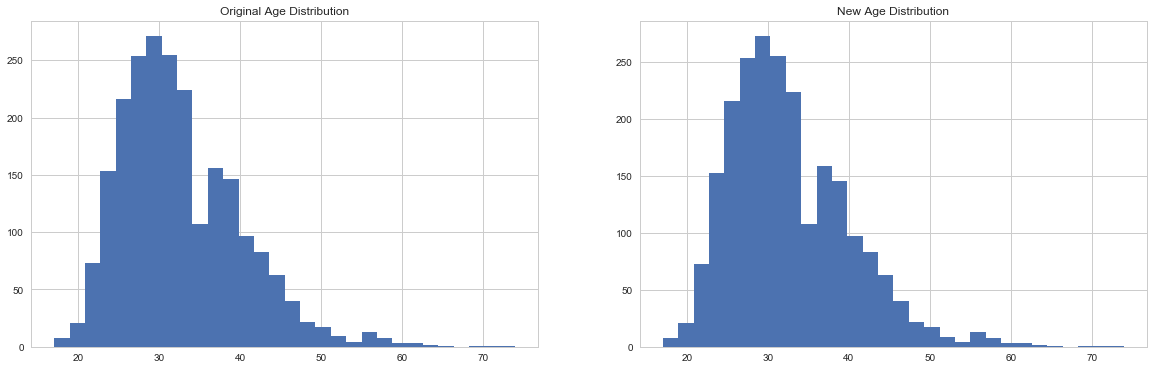

In [97]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 6))
axis1.set_title('Original Age Distribution')
axis2.set_title('New Age Distribution')

# get median, Q1, Q3, and number of outlier ages
typical_ages = combined_df.loc[(combined_df.age >= 17) & (combined_df.age <= 90), 'age']
outlier_ages = combined_df.loc[(combined_df.age > 90) | (combined_df.age < 17), 'age']
median_age = typical_ages.median()
q1_age = typical_ages.quantile(0.25)
q3_age = typical_ages.quantile(0.75)
num_outlier_ages = len(outlier_ages)

# generate random ages between mean +/- std
new_ages = np.random.randint(q1_age, q3_age, size=num_outlier_ages)

# plot orig age distrib without the outliers
typical_ages.hist(bins=30, ax=axis1)

# fill outlier ages with new values
combined_df.loc[(combined_df.age > 90) | (combined_df.age < 17), 'age'] = new_ages
combined_df.age = combined_df.age.astype(int)

# plot age distribution with new values
combined_df.age.hist(bins=30, ax=axis2)

### Gender

In [98]:
# Separate all the unique responses into male, female, and other
all_gender = list(combined_df.gender.unique())
condit_female = ['Female', 'female', 'F', 'f', 'Femake', 'woman', 'Female ', 'Woman', 'femail',
                'I identify as female.', 'fm', 'female/woman', 'female ', 'fem',
                'Female (props for making this a freeform field, though)', ' Female']
condit_male = ['M', 'Male', 'male', 'maile', 'm', 'Make', 'Male ', 'Man', 'msle', 'Mail', 'Malr', 'man', 'Male.',
              'Sex is male', 'Dude', 'mail', 'male ']
condit_other = [i for i in all_gender if (i not in condit_male) and (i not in condit_female)] 

In [99]:
# Reduce to numerical values according to each category
# male = -1 ; other = 0 ; female = 1
combined_df.loc[(combined_df.gender.isin(condit_male)), 'gender'] = -1
combined_df.loc[(combined_df.gender.isin(condit_other)), 'gender'] = 0
combined_df.loc[(combined_df.gender.isin(condit_female)), 'gender'] = 1

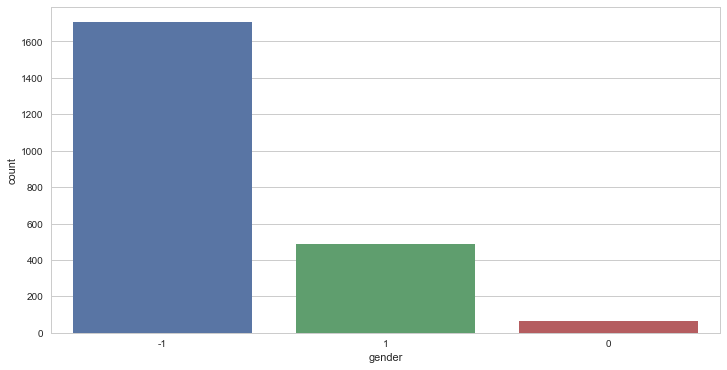

In [100]:
# plot counts for each gender
fig, axis = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x='gender', data=combined_df, ax=axis, order=combined_df.gender.value_counts().index)

### Location

In [101]:
# Drop country_live = Other
combined_df.drop(combined_df[combined_df.country_live == 'Other'].index, axis=0, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

In [102]:
# Put together the USA & US responses
combined_df.loc[(combined_df.country_live == 'United States of America'), 'country_live'] = 'United States'

In [103]:
# Set state_live = NaN for non USA countries
combined_df.loc[(
    combined_df.state_live.notnull()) & (
    combined_df.country_live != 'United States'), 'state_live'] = np.nan

In [104]:
# Set state_live = the mode (California) for USA responses with NaN state_live
combined_df.loc[(
    combined_df.state_live.isnull()) & (
    combined_df.country_live == 'United States'), 'state_live'] = 'California'

In [105]:
# Convert abbrev. state_live responses to full name
state_abbr_full = {'IL': 'Illinois', 'IN': 'Indiana', 'TX': 'Texas', 'TN': 'Tennessee', 'MI': 'Michigan',
                  'OH': 'Ohio', 'CA': 'California', 'CT': 'Connecticut', 'NY': 'New York', 'MA': 'Massachusetts',
                  'IA': 'Iowa', 'WA': 'Washington', 'WI': 'Wisconsin', 'UT': 'Utah', 'NM': 'New Mexico',
                  'OR': 'Oregon', 'FL': 'Florida', 'MN': 'Minnesota', 'MO': 'Missouri', 'AZ': 'Arizona',
                  'CO': 'Colorado', 'GA': 'Georgia', 'DC': 'District of Columbia', 'NE': 'Nebraska',
                  'MD': 'Maryland', 'PA': 'Pennsylvania', 'WV': 'West Virginia', 'OK': 'Oklahoma',
                  'NC': 'North Carolina', 'KS': 'Kansas', 'VA': 'Virginia', 'NH': 'New Hampshire', 'KY': 'Kentucky',
                  'AL': 'Alabama', 'NV': 'Nevada', 'NJ': 'New Jersey', 'SC': 'South Carolina', 'VT': 'Vermont',
                  'SD': 'South Dakota', 'ID': 'Idaho', 'RI': 'Rhode Island', 'WY': 'Wyoming', 'LA': 'Louisiana',
                  'ME': 'Maine', 'AK': 'Alaska', 'AR': 'Arkansas', 'DE': 'Delaware', 'HI': 'Hawaii',
                  'MS': 'Mississippi', 'MT': 'Montana', 'ND': 'North Dakota'}
combined_df.loc[(combined_df.state_live.str.len() == 2), 'state_live'] = combined_df.loc[(combined_df.state_live.str.len() == 2), 'state_live'].map(state_abbr_full)

In [106]:
# Create feature 'location' that splits USA by states and considers them on same level as other countries
combined_df['location'] = combined_df.country_live
combined_df.loc[(
    combined_df.state_live.notnull()) & (
    combined_df.country_live == 'United States'), 'location'] = combined_df.state_live

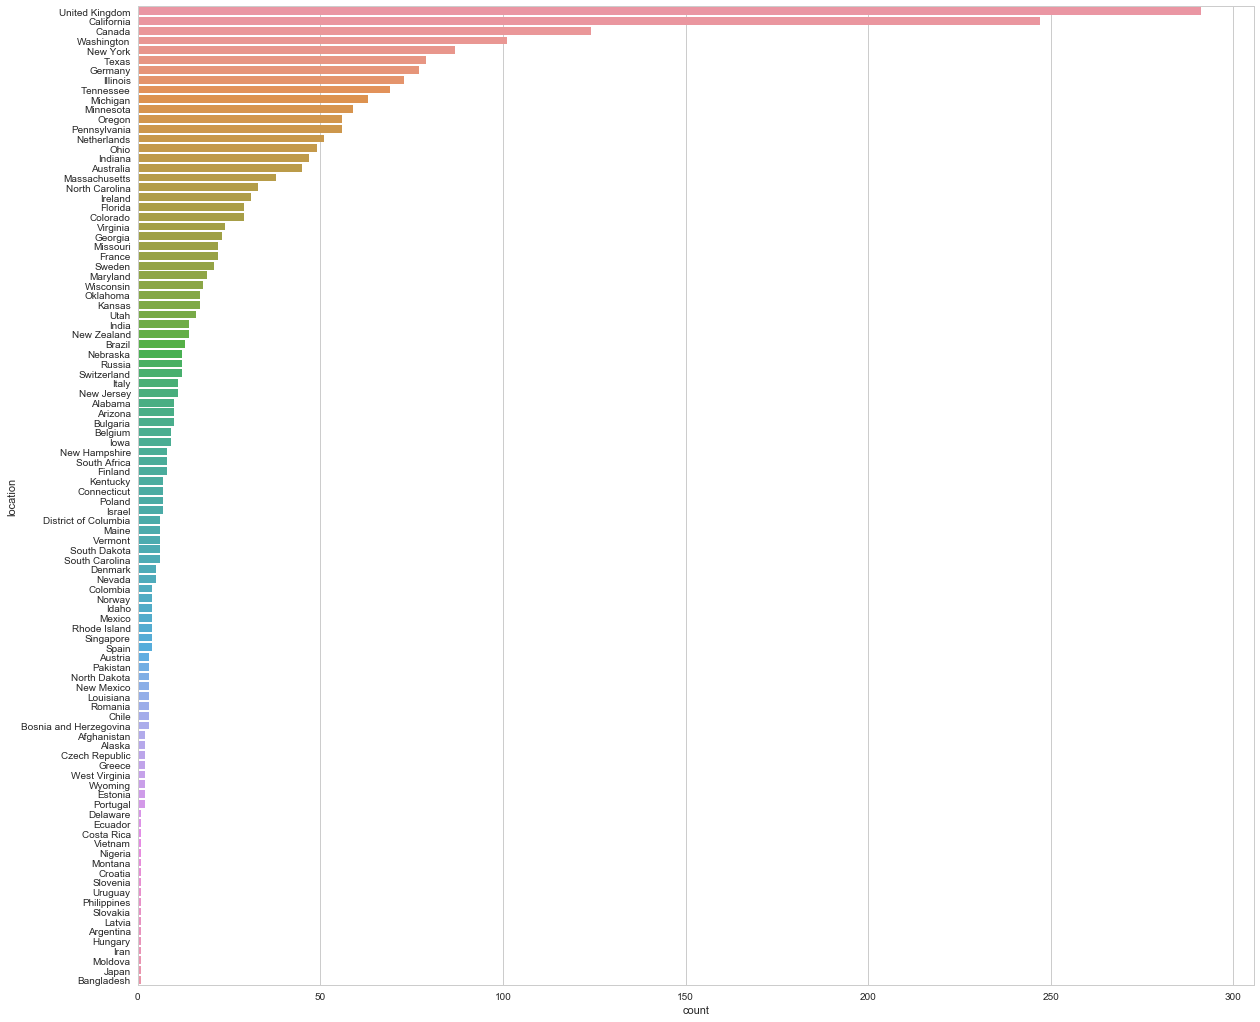

In [108]:
fig, axis = plt.subplots(1, 1, figsize=(20,18))
sns.countplot(y='location', data=combined_df, ax=axis, order=combined_df.location.value_counts().index)

### Family History of Mental Illness

In [109]:
# Reduce to numerical
# No = -1 ; don't know = 0 ; yes = 1
combined_df.loc[(combined_df.family_history == 'No'), 'family_history'] = -1
combined_df.loc[(combined_df.family_history == 'I don\'t know'), 'family_history'] = 0
combined_df.loc[(combined_df.family_history == 'Yes'), 'family_history'] = 1

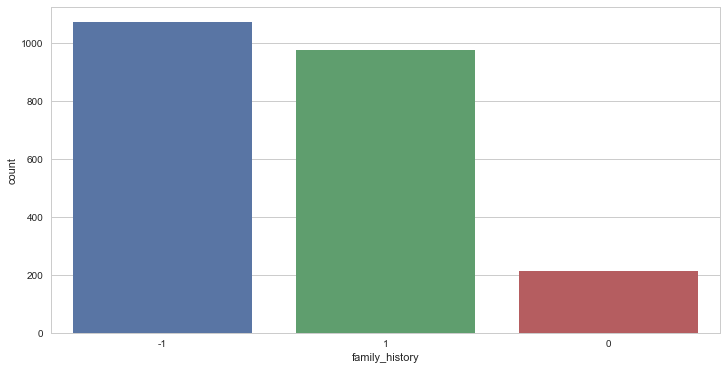

In [110]:
# plot counts
fig, axis = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x='family_history', data=combined_df, ax=axis, order=combined_df.family_history.value_counts().index)

### Sought Treatment

In [111]:
# Relabel yes = 1, no = 0
combined_df.loc[(combined_df.treatment == 'No'), 'treatment'] = 0
combined_df.loc[(combined_df.treatment == 'Yes'), 'treatment'] = 1

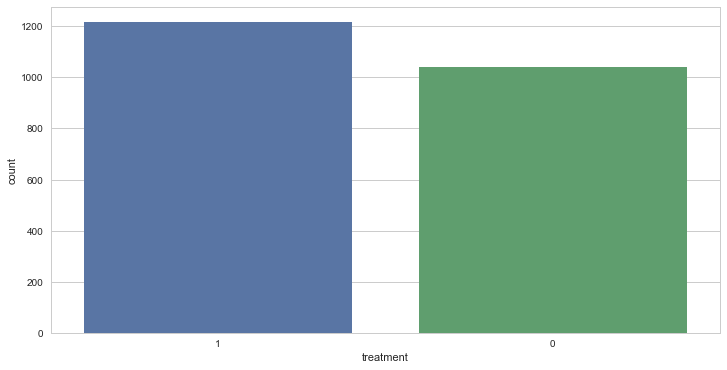

In [112]:
# plot counts
fig, axis = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x='treatment', data=combined_df, ax=axis, order=combined_df.treatment.value_counts().index)

### Interferes With Work

In [113]:
# Lump 'Not applicable to me' with NaN
combined_df.loc[combined_df.work_interfere == 'Not applicable to me', 'work_interfere'] = np.nan

In [114]:
# According to OSMI Survey: 
# 'This survey is for everyone working in tech, not just those who have a mental health issue.'
# Assumption: IF work_interfere == N/A THEN treatment == 0 AND has_illness = 0
combined_df.loc[(combined_df.work_interfere.isnull()), 'treatment'] = 0

In [115]:
# One-Hot Encode
work_int_dummies = pd.get_dummies(combined_df.work_interfere.str.lower(), prefix='wint', dummy_na=True)
combined_df = combined_df.join(work_int_dummies)

### Number of Employees

In [116]:
# Convert num_employees into new features: sm_comp, med_comp, lg_comp
num_emp_map = {'1-5': 'sm', '6-25': 'sm', '26-100': 'sm',
               '100-500': 'med', '500-1000': 'med', 'More than 1000': 'lg'}
combined_df['company_size'] = combined_df.num_employees.map(num_emp_map)

In [119]:
# One-Hot Encode
comp_size_dummies = pd.get_dummies(combined_df.company_size, prefix='comp')
combined_df = combined_df.join(comp_size_dummies)